In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn import preprocessing
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
raw_data = fetch_california_housing()
data = raw_data.data 

In [3]:
lower_percent = np.percentile(data, 1, axis=0)
higher_percent = np.percentile(data, 99, axis=0)

result = np.array([True for i in range(data.shape[0])])
for i in range(len(raw_data.feature_names)):
    lower = data[:,i] >= lower_percent[i]
    higher = data[:,i] <= higher_percent[i]
    result = np.logical_and(result, np.logical_and(lower, higher))
    
data = data[result]

In [4]:
data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [5]:
data.shape

(18310, 8)

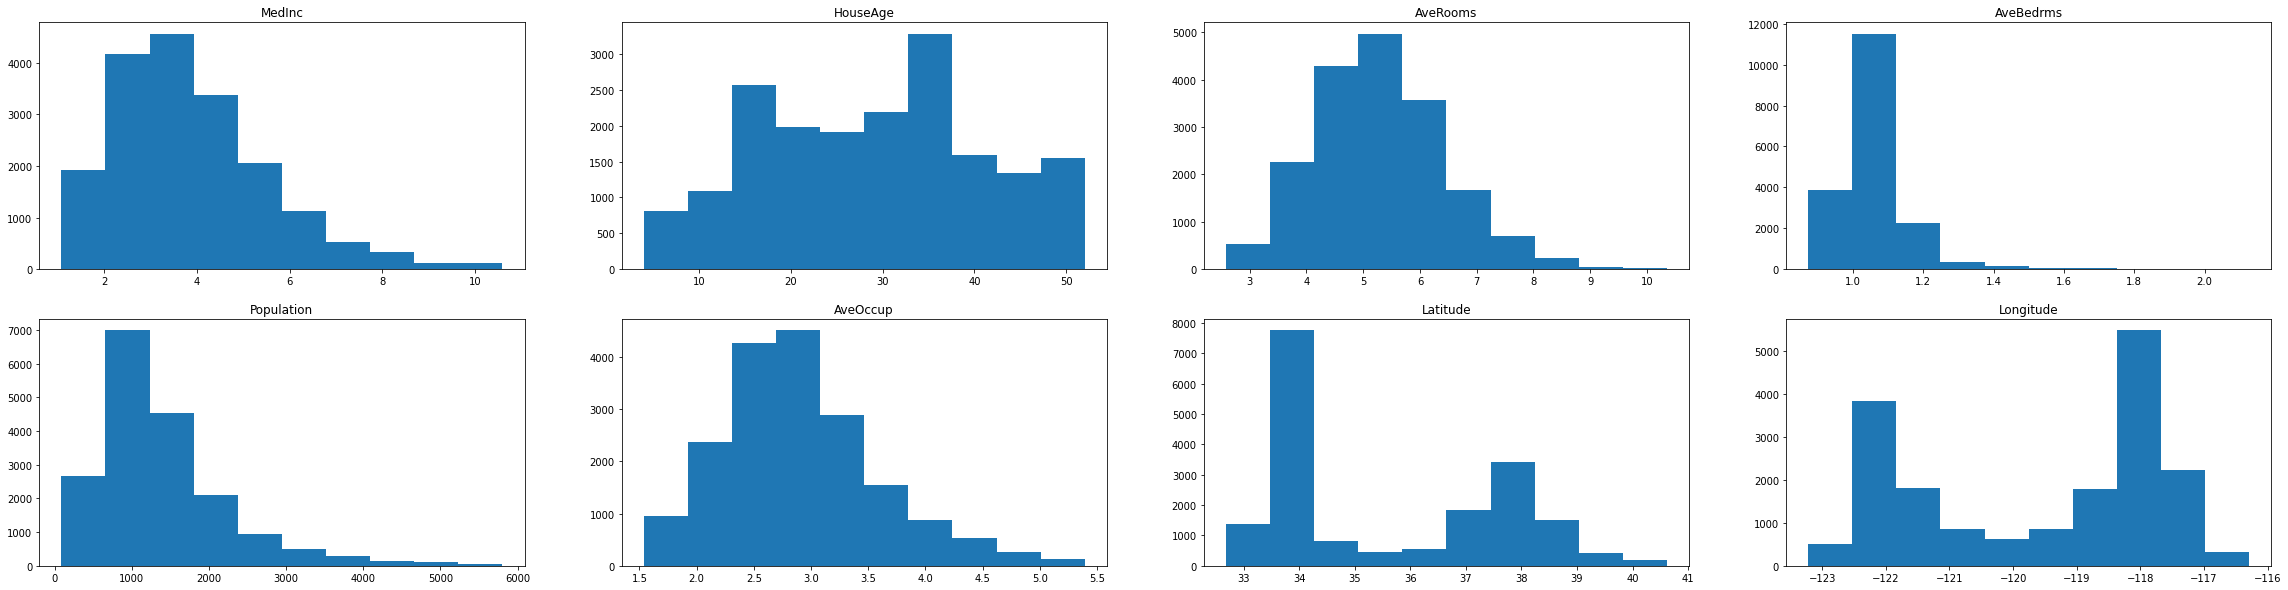

In [6]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))

for i in range(2):
    for j in range(4): 
        axs[i, j].hist(data[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
plt.show()

In [7]:
# Preprocessing 
print(data.shape)
np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10 

X_train = data[:trainset_size, :]
X_test = data[trainset_size:, :]
print(X_train.shape)
print(X_test.shape)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

(18310, 8)
(12817, 8)
(5493, 8)


In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = self.dropout(F.relu(self.hidden(out)))
#         out = F.relu(self.hidden2(out))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z 

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [9]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 15
LATENT_DIM = 10
BATCH_SIZE = 128
N_EPOCHS = 1000
lr = 1e-5

In [10]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [11]:
avg_mu_x = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + torch.exp(std_z) * eps
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x.shape

avg_mu_x = avg_mu_x.detach().numpy()

In [12]:
avg_mu_x

array([[ 0.1181784 , -0.22215284,  0.06512694, ..., -0.14483368,
         0.09241558, -0.2662163 ],
       [ 0.11788265, -0.22345585,  0.06950504, ..., -0.140209  ,
         0.09073249, -0.27219734],
       [ 0.1200365 , -0.21729656,  0.06511854, ..., -0.14578466,
         0.09496802, -0.267437  ],
       ...,
       [ 0.11974181, -0.22387701,  0.07185744, ..., -0.14081675,
         0.09082335, -0.26833072],
       [ 0.11795201, -0.22228752,  0.06268247, ..., -0.14580359,
         0.09610429, -0.26401496],
       [ 0.11629199, -0.22217685,  0.05478835, ..., -0.14762467,
         0.09179273, -0.27060854]], dtype=float32)

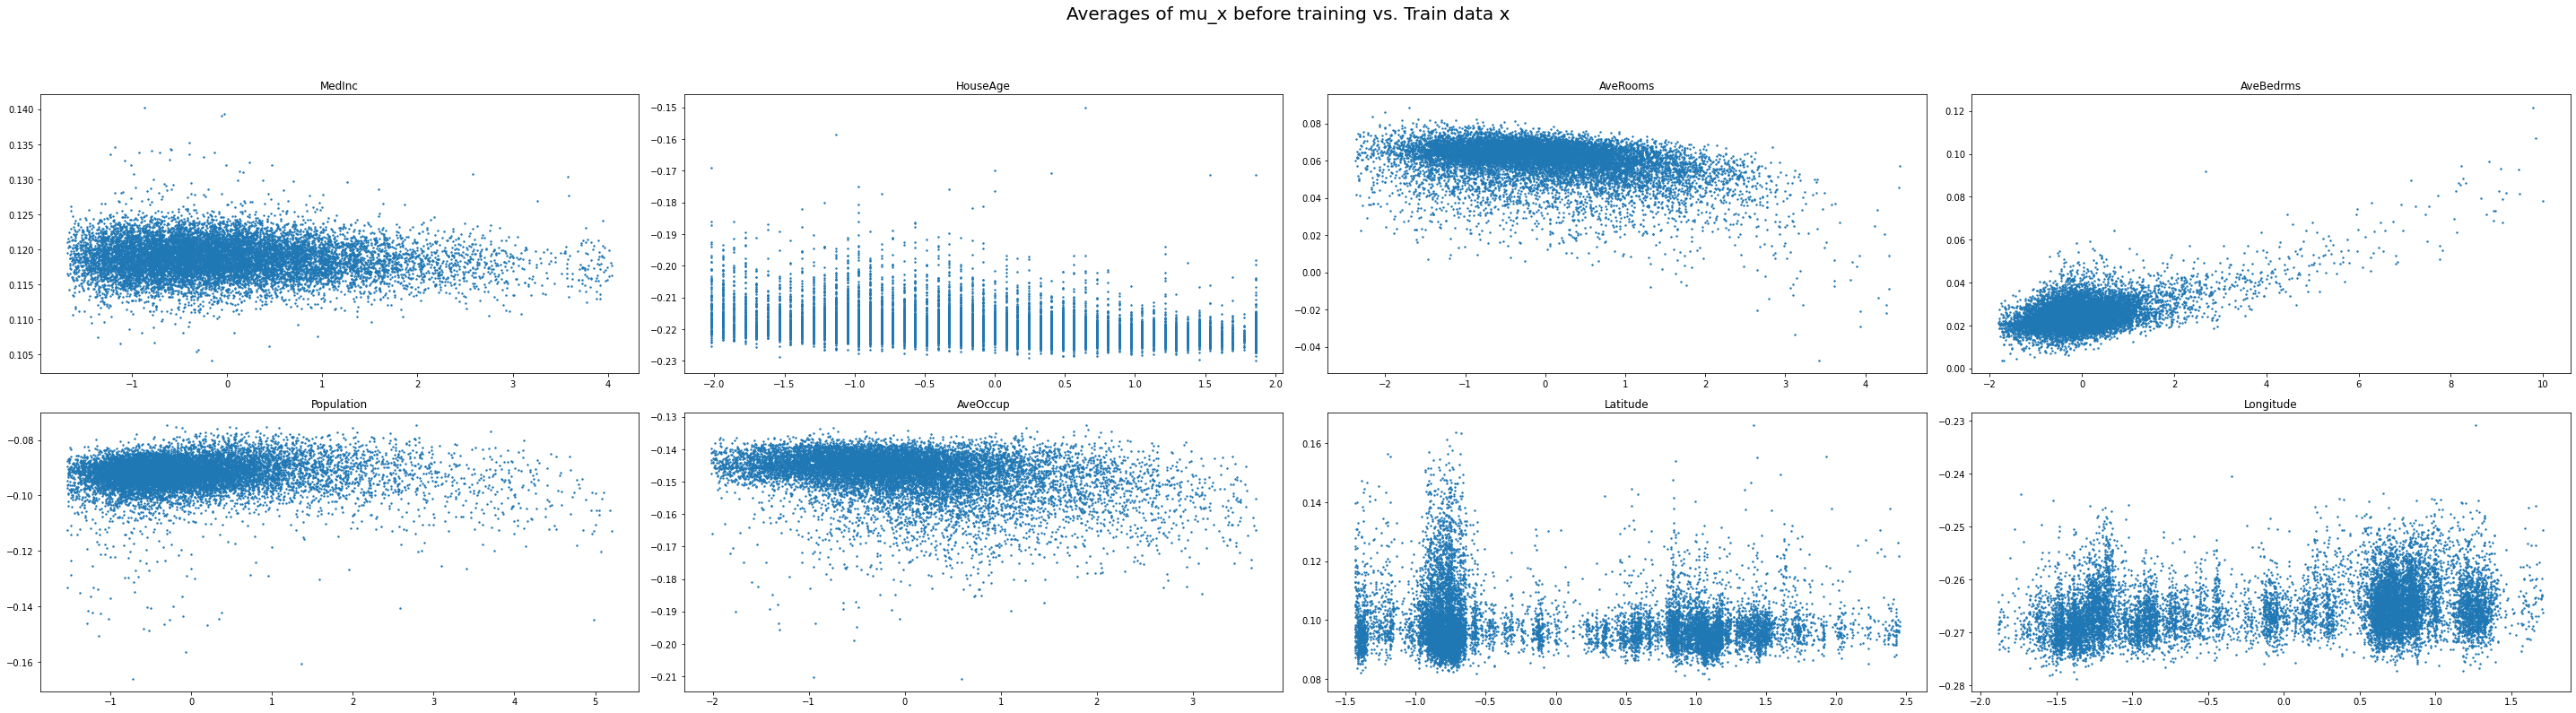

In [13]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
for i in range(2): 
    for j in range(4): 
        axs[i, j].scatter(X_train[:, i*4+j], avg_mu_x[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])

figs.tight_layout()
plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=20, y=1.1)
plt.show()

In [14]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z)
#         torch.sum(log_p_x) - torch.sum(log_p_z)
    )
    
    return loss

In [15]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [16]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)
test_iter = DataLoader(X_test, batch_size=BATCH_SIZE)

In [17]:
train_loss_avg = []
test_loss_avg = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x in train_iter: 
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        mu_x, std_x = dec(z_samples)
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
#     scheduler.step()
    train_loss_avg[-1] /= num_batches

    
    with torch.no_grad():
        test_loss_avg.append(0)
        num_batches = 0
        for x_test in test_iter:
            # test
            mu_z_test, std_z_test = enc(x_test)
            eps_test = torch.randn_like(std_z_test)
            z_samples_test = mu_z_test + eps_test * torch.exp(std_z_test)

            mu_x_test, std_x_test = dec(z_samples_test)

            # loss 
            test_loss = loss_fn(mu_z_test, std_z_test, z_samples_test, mu_x_test, std_x_test, x_test)
            test_loss_avg[-1] += test_loss.item()
            num_batches += 1
        test_loss_avg[-1] /= num_batches
    
#     if i > 50: 
#         prev_mean = sum(train_loss_avg[i-50:i])/50
#         curr_mean = sum(train_loss_avg[i-49:i+1])/50
#         if 0 <= ((prev_mean - curr_mean) / prev_mean) <= 0.00001:
#             print("CONVERGED!!!!")
#             break 
    
    print("Epoch [%d / %d] train loss: %f, test loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1], test_loss_avg[-1]))

Epoch [1 / 1000] train loss: 12.654949, test loss: 12.623855
Epoch [2 / 1000] train loss: 12.570787, test loss: 12.617535
Epoch [3 / 1000] train loss: 12.569464, test loss: 12.535531
Epoch [4 / 1000] train loss: 12.536868, test loss: 12.524810
Epoch [5 / 1000] train loss: 12.513118, test loss: 12.498560
Epoch [6 / 1000] train loss: 12.502963, test loss: 12.471101
Epoch [7 / 1000] train loss: 12.462422, test loss: 12.450467
Epoch [8 / 1000] train loss: 12.416377, test loss: 12.405484
Epoch [9 / 1000] train loss: 12.404130, test loss: 12.412150
Epoch [10 / 1000] train loss: 12.399989, test loss: 12.397768
Epoch [11 / 1000] train loss: 12.353183, test loss: 12.344849
Epoch [12 / 1000] train loss: 12.341162, test loss: 12.309349
Epoch [13 / 1000] train loss: 12.288500, test loss: 12.309711
Epoch [14 / 1000] train loss: 12.278813, test loss: 12.309464
Epoch [15 / 1000] train loss: 12.268158, test loss: 12.294198
Epoch [16 / 1000] train loss: 12.251969, test loss: 12.242955
Epoch [17 / 1000]

Epoch [133 / 1000] train loss: 11.468267, test loss: 11.478974
Epoch [134 / 1000] train loss: 11.469492, test loss: 11.466625
Epoch [135 / 1000] train loss: 11.462807, test loss: 11.467849
Epoch [136 / 1000] train loss: 11.467293, test loss: 11.471129
Epoch [137 / 1000] train loss: 11.457117, test loss: 11.457447
Epoch [138 / 1000] train loss: 11.464424, test loss: 11.470033
Epoch [139 / 1000] train loss: 11.468122, test loss: 11.474182
Epoch [140 / 1000] train loss: 11.454644, test loss: 11.466730
Epoch [141 / 1000] train loss: 11.449546, test loss: 11.467282
Epoch [142 / 1000] train loss: 11.458392, test loss: 11.460842
Epoch [143 / 1000] train loss: 11.451521, test loss: 11.470382
Epoch [144 / 1000] train loss: 11.450961, test loss: 11.435833
Epoch [145 / 1000] train loss: 11.445519, test loss: 11.466685
Epoch [146 / 1000] train loss: 11.448845, test loss: 11.457277
Epoch [147 / 1000] train loss: 11.450916, test loss: 11.454915
Epoch [148 / 1000] train loss: 11.445716, test loss: 11

Epoch [264 / 1000] train loss: 11.371944, test loss: 11.392815
Epoch [265 / 1000] train loss: 11.381408, test loss: 11.373869
Epoch [266 / 1000] train loss: 11.383306, test loss: 11.387787
Epoch [267 / 1000] train loss: 11.377954, test loss: 11.384904
Epoch [268 / 1000] train loss: 11.377812, test loss: 11.379876
Epoch [269 / 1000] train loss: 11.370012, test loss: 11.391335
Epoch [270 / 1000] train loss: 11.378885, test loss: 11.387962
Epoch [271 / 1000] train loss: 11.369942, test loss: 11.381182
Epoch [272 / 1000] train loss: 11.368580, test loss: 11.379585
Epoch [273 / 1000] train loss: 11.375646, test loss: 11.376125
Epoch [274 / 1000] train loss: 11.373173, test loss: 11.374249
Epoch [275 / 1000] train loss: 11.368936, test loss: 11.379107
Epoch [276 / 1000] train loss: 11.374884, test loss: 11.379177
Epoch [277 / 1000] train loss: 11.368228, test loss: 11.378181
Epoch [278 / 1000] train loss: 11.377794, test loss: 11.374212
Epoch [279 / 1000] train loss: 11.375819, test loss: 11

Epoch [395 / 1000] train loss: 11.329581, test loss: 11.334608
Epoch [396 / 1000] train loss: 11.330231, test loss: 11.333509
Epoch [397 / 1000] train loss: 11.322621, test loss: 11.329289
Epoch [398 / 1000] train loss: 11.330737, test loss: 11.329070
Epoch [399 / 1000] train loss: 11.322131, test loss: 11.334011
Epoch [400 / 1000] train loss: 11.338328, test loss: 11.342439
Epoch [401 / 1000] train loss: 11.323838, test loss: 11.331748
Epoch [402 / 1000] train loss: 11.328605, test loss: 11.332584
Epoch [403 / 1000] train loss: 11.331199, test loss: 11.326551
Epoch [404 / 1000] train loss: 11.339547, test loss: 11.333757
Epoch [405 / 1000] train loss: 11.323999, test loss: 11.329847
Epoch [406 / 1000] train loss: 11.329664, test loss: 11.327530
Epoch [407 / 1000] train loss: 11.325374, test loss: 11.342049
Epoch [408 / 1000] train loss: 11.330976, test loss: 11.333678
Epoch [409 / 1000] train loss: 11.331500, test loss: 11.334116
Epoch [410 / 1000] train loss: 11.323352, test loss: 11

Epoch [526 / 1000] train loss: 11.279507, test loss: 11.274884
Epoch [527 / 1000] train loss: 11.272206, test loss: 11.278305
Epoch [528 / 1000] train loss: 11.271268, test loss: 11.274849
Epoch [529 / 1000] train loss: 11.280284, test loss: 11.272169
Epoch [530 / 1000] train loss: 11.293498, test loss: 11.282452
Epoch [531 / 1000] train loss: 11.280070, test loss: 11.262680
Epoch [532 / 1000] train loss: 11.270638, test loss: 11.261684
Epoch [533 / 1000] train loss: 11.269519, test loss: 11.268938
Epoch [534 / 1000] train loss: 11.276991, test loss: 11.272490
Epoch [535 / 1000] train loss: 11.272232, test loss: 11.280782
Epoch [536 / 1000] train loss: 11.277167, test loss: 11.274980
Epoch [537 / 1000] train loss: 11.271854, test loss: 11.255714
Epoch [538 / 1000] train loss: 11.276012, test loss: 11.254088
Epoch [539 / 1000] train loss: 11.267730, test loss: 11.268369
Epoch [540 / 1000] train loss: 11.273152, test loss: 11.276314
Epoch [541 / 1000] train loss: 11.271015, test loss: 11

Epoch [657 / 1000] train loss: 11.238534, test loss: 11.214399
Epoch [658 / 1000] train loss: 11.229047, test loss: 11.231775
Epoch [659 / 1000] train loss: 11.248975, test loss: 11.232103
Epoch [660 / 1000] train loss: 11.243632, test loss: 11.238289
Epoch [661 / 1000] train loss: 11.238940, test loss: 11.237713
Epoch [662 / 1000] train loss: 11.243485, test loss: 11.227073
Epoch [663 / 1000] train loss: 11.240321, test loss: 11.219040
Epoch [664 / 1000] train loss: 11.234460, test loss: 11.233805
Epoch [665 / 1000] train loss: 11.236666, test loss: 11.236554
Epoch [666 / 1000] train loss: 11.235152, test loss: 11.238277
Epoch [667 / 1000] train loss: 11.210745, test loss: 11.231234
Epoch [668 / 1000] train loss: 11.224888, test loss: 11.242874
Epoch [669 / 1000] train loss: 11.220693, test loss: 11.220657
Epoch [670 / 1000] train loss: 11.239725, test loss: 11.238805
Epoch [671 / 1000] train loss: 11.231313, test loss: 11.223120
Epoch [672 / 1000] train loss: 11.244372, test loss: 11

Epoch [788 / 1000] train loss: 11.210880, test loss: 11.200346
Epoch [789 / 1000] train loss: 11.206772, test loss: 11.212885
Epoch [790 / 1000] train loss: 11.200096, test loss: 11.221973
Epoch [791 / 1000] train loss: 11.199122, test loss: 11.219128
Epoch [792 / 1000] train loss: 11.207880, test loss: 11.223486
Epoch [793 / 1000] train loss: 11.228157, test loss: 11.196270
Epoch [794 / 1000] train loss: 11.208000, test loss: 11.214275
Epoch [795 / 1000] train loss: 11.211444, test loss: 11.227285
Epoch [796 / 1000] train loss: 11.213073, test loss: 11.185491
Epoch [797 / 1000] train loss: 11.197949, test loss: 11.198998
Epoch [798 / 1000] train loss: 11.223058, test loss: 11.213242
Epoch [799 / 1000] train loss: 11.205224, test loss: 11.217075
Epoch [800 / 1000] train loss: 11.207802, test loss: 11.205948
Epoch [801 / 1000] train loss: 11.194037, test loss: 11.202054
Epoch [802 / 1000] train loss: 11.207702, test loss: 11.211494
Epoch [803 / 1000] train loss: 11.199708, test loss: 11

Epoch [919 / 1000] train loss: 11.194940, test loss: 11.221570
Epoch [920 / 1000] train loss: 11.209015, test loss: 11.205095
Epoch [921 / 1000] train loss: 11.191431, test loss: 11.203326
Epoch [922 / 1000] train loss: 11.195893, test loss: 11.208353
Epoch [923 / 1000] train loss: 11.188217, test loss: 11.193030
Epoch [924 / 1000] train loss: 11.197611, test loss: 11.179400
Epoch [925 / 1000] train loss: 11.216065, test loss: 11.180399
Epoch [926 / 1000] train loss: 11.191819, test loss: 11.189058
Epoch [927 / 1000] train loss: 11.203777, test loss: 11.193750
Epoch [928 / 1000] train loss: 11.212410, test loss: 11.180602
Epoch [929 / 1000] train loss: 11.206249, test loss: 11.199778
Epoch [930 / 1000] train loss: 11.204874, test loss: 11.190854
Epoch [931 / 1000] train loss: 11.207106, test loss: 11.200681
Epoch [932 / 1000] train loss: 11.206336, test loss: 11.221638
Epoch [933 / 1000] train loss: 11.185586, test loss: 11.194700
Epoch [934 / 1000] train loss: 11.226731, test loss: 11

1000
1000


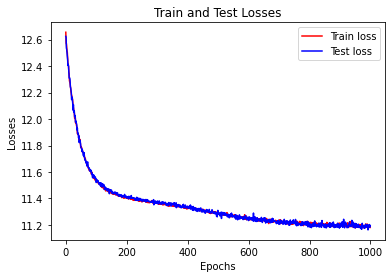

In [18]:
print(len(train_loss_avg))
print(len(test_loss_avg))
plt.plot(train_loss_avg, "r")
plt.plot(test_loss_avg, "b")
plt.legend(["Train loss", "Test loss"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
# plt.ylim(10.5, 11.5)
plt.title("Train and Test Losses")
plt.show()

In [19]:
avg_mu_x_trained = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_trained += mu_x

avg_mu_x_trained /= 100
avg_mu_x_trained = avg_mu_x_trained.detach().numpy()

In [20]:
avg_mu_x_trained

array([[ 0.01042055,  0.0228629 , -0.05528062, ...,  0.02254382,
        -0.02303527,  0.00339002],
       [ 0.00986564,  0.02445115, -0.05596514, ...,  0.02273777,
        -0.02286254,  0.00389426],
       [ 0.01104486,  0.02414321, -0.05689608, ...,  0.02274441,
        -0.02144348,  0.00358485],
       ...,
       [ 0.01119219,  0.02421637, -0.05682191, ...,  0.02245203,
        -0.02226213,  0.00396747],
       [ 0.01367977,  0.02021226, -0.05366465, ...,  0.02114225,
        -0.0242279 ,  0.00377319],
       [ 0.01107794,  0.02409202, -0.05646021, ...,  0.02282757,
        -0.02242113,  0.00349386]], dtype=float32)

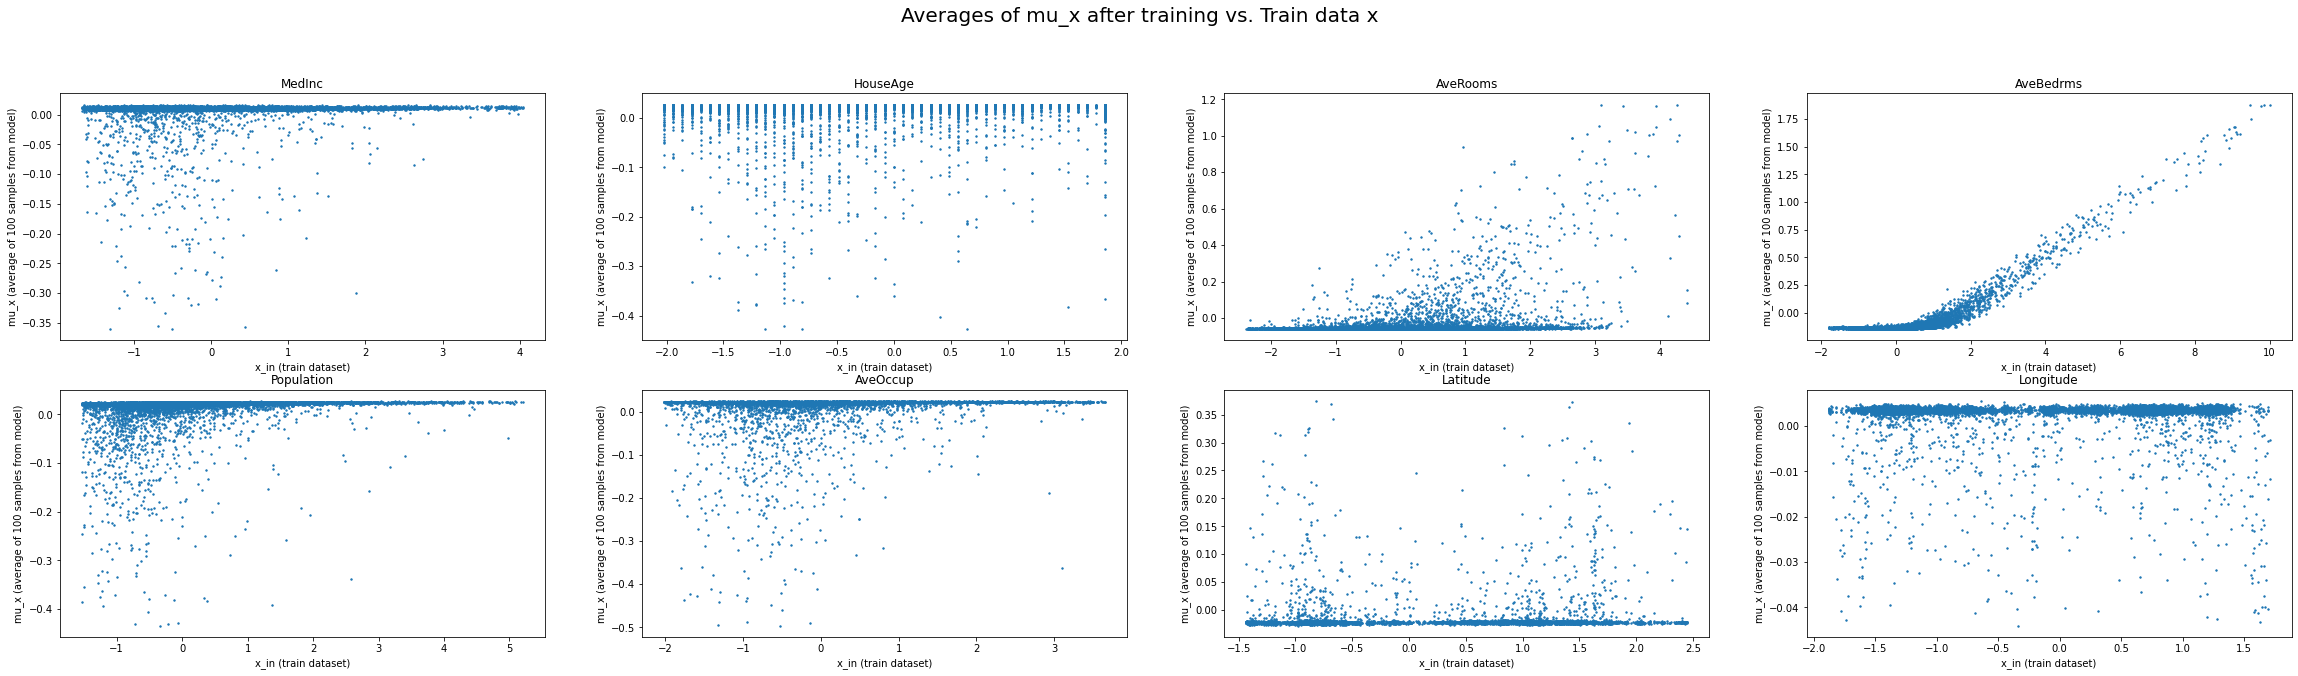

In [21]:
# avg_mu_x_trained = avg_mu_x_trained.detach().numpy()
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
count = 0 
for i in range(2):
    for j in range(4):
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x_trained[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (train dataset)")

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=20, y=1)
plt.show()

In [22]:
import matplotlib.colors as mcolors
import seaborn as sns

levs = range(12)
assert len(levs) % 2 == 0, 'N levels must be even.'

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0), 
                                                          (1, 1., 1), 
                                                          (0, 0, 1)],
                                                 N=len(levs)-1)

In [23]:
p_z = torch.distributions.Normal(0, 1)
z = p_z.sample((1000, LATENT_DIM)).type(torch.float64)
mu_x, std_x = dec(z)
print(mu_x.shape)

torch.Size([1000, 8])


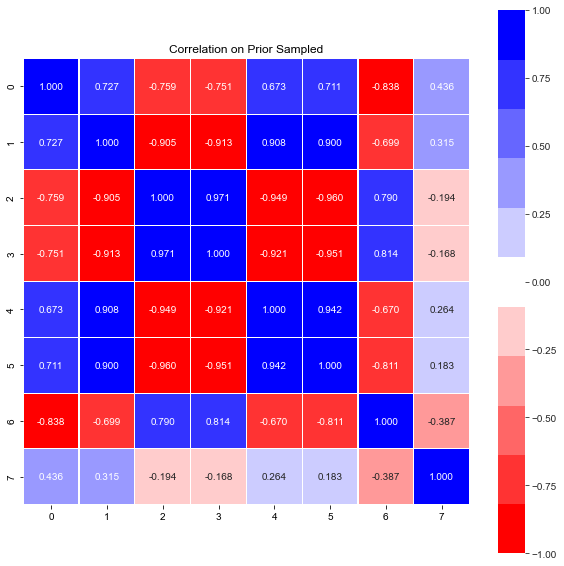

In [24]:
mu_x = mu_x.detach().numpy()
corr_eval = np.corrcoef(mu_x, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_eval, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Prior Sampled")
    plt.show()

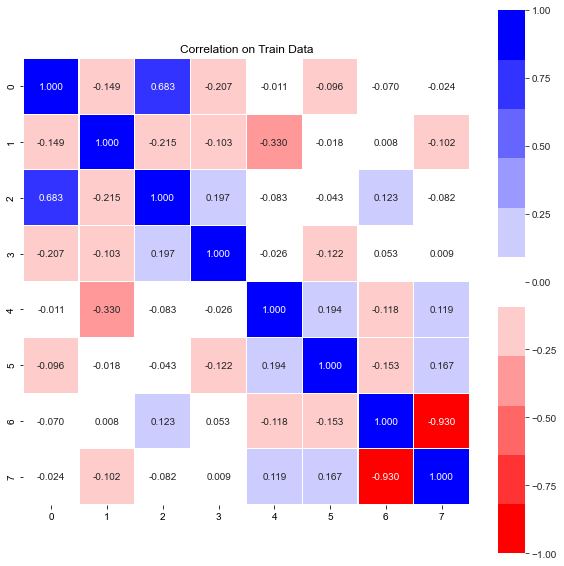

In [25]:
corr_train = np.corrcoef(X_train, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_train, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Train Data")
    plt.show()

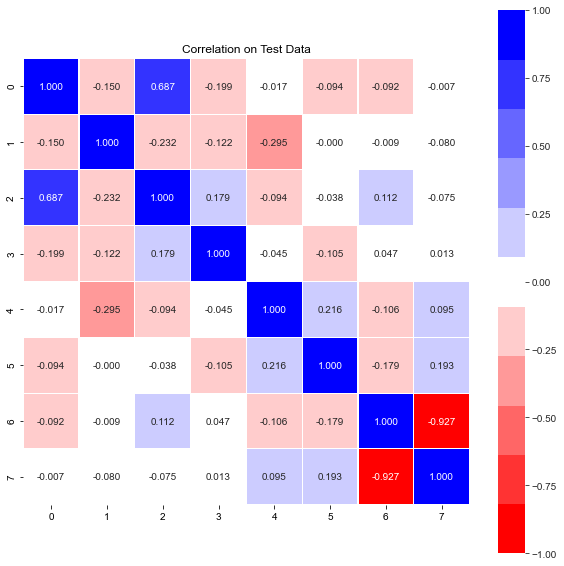

In [26]:
corr_test = np.corrcoef(X_test, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))  
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Test Data")
    plt.show()

In [27]:
# z = torch.distributions.Uniform(0, 1).sample((X_test.shape[0], LATENT_DIM)).type(torch.float64)
# mu_x, std_x = dec(z)

# # X_test = X_test.numpy()
# mu_x = mu_x.detach().numpy()

# figs, axs = plt.subplots(X_test.shape[1], 2, figsize=(20, 100))

# for i in range(X_test.shape[1]):
# #     x_test_mean = x_test[:,i].mean()
#     axs[i, 0].hist(X_test[:,i])
#     axs[i, 0].set_title("Histogram of Held Out Data on Feature " + raw_data.feature_names[i])
#     axs[i, 1].hist(mu_x[:,i])
#     axs[i, 1].set_title("Histogram of Sampled Data on Feature " + raw_data.feature_names[i])

# plt.show()